In [1]:
!python -c "import torch; print(torch.version.cuda)"

12.4


In [4]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
  -f https://data.pyg.org/whl/torch-2.4.0+cu124.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 116.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 995.9/995.9 kB 924.1 kB/s eta 0:00:00


In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  import torch_geometric.typing
/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  import torch_geometric.typing
/usr/local/lib/python3.11/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_basis_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2

In [6]:
#  basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, I used it as new data object
data = dataset[0]

#  some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [7]:
print(data.x.shape) # [No. Nodes x Features]

#  some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [8]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [9]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [10]:
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [12]:
# Initializing model
model = GCN(hidden_channels=16)

# Using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initializing Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
# Defining loss function (CrossEntropyLoss for Classification Problems with
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      # Using all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)
      # Only used nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Used the class with highest probability.
      pred = out.argmax(dim=1)
      # Checked against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derived ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.7376
Epoch: 200, Loss: 1.5091
Epoch: 300, Loss: 1.4761
Epoch: 400, Loss: 1.4391
Epoch: 500, Loss: 1.3845
Epoch: 600, Loss: 1.3568
Epoch: 700, Loss: 1.3690
Epoch: 800, Loss: 1.3570
Epoch: 900, Loss: 1.3648
Epoch: 1000, Loss: 1.3656


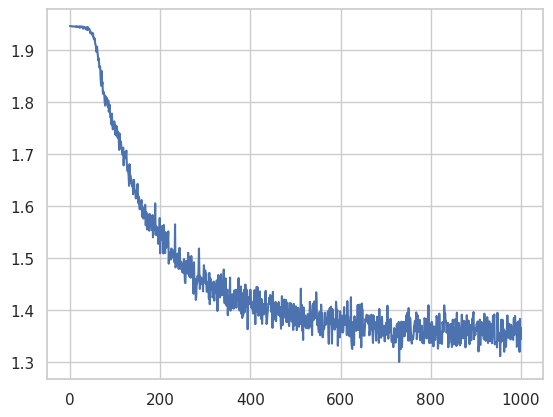

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt  # to show the plot

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = list(range(len(losses_float)))

sns.lineplot(x=loss_indices, y=losses_float)
plt.show()


In [14]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6840


torch.Size([2708, 7])


<Axes: >

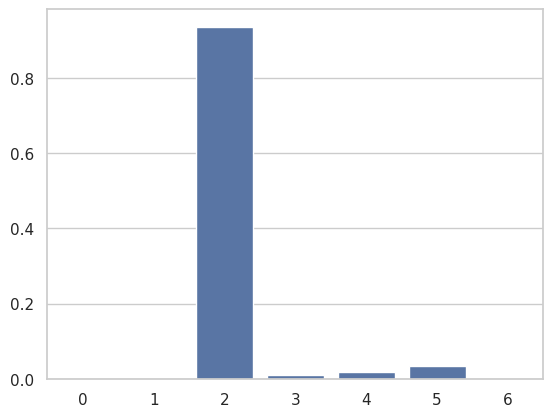

In [15]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())